In [229]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import seaborn as sns

[nltk_data] Downloading package punkt_tab to /Users/sahil/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sahil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1)loading the data

In [230]:
data=pd.read_csv("/Users/sahil/Programs/projects/MSA/Assignments/train.csv")

In [231]:
def clean_location_and_keyword(df):
    if 'location' in df.columns:
        df['location'] = df['location'].fillna('Unknown') 
    if 'keyword' in df.columns:
        df['keyword'] = df['keyword'].fillna('Unknown')  
    return
clean_location_and_keyword(data)


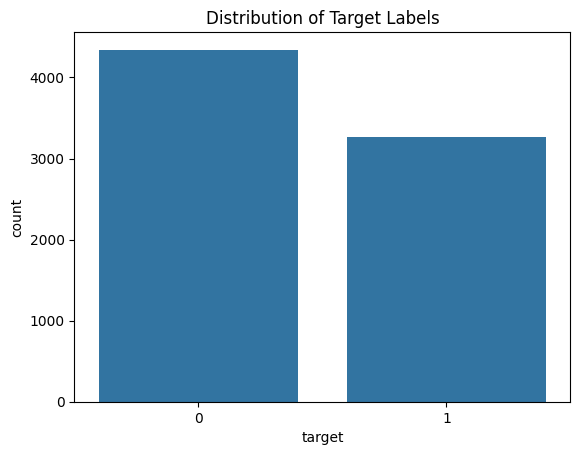

In [232]:
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Labels')
plt.show()

2)text preprocessing

In [233]:
def clean_tex(tex):
    cleaned_tweet = re.sub(r"[^a-zA-Z\s]", "", tex)
    return cleaned_tweet.strip()

cleaned_text = data['text'].apply(clean_tex)
stop_words = set(stopwords.words('english'))


In [234]:
tokens=cleaned_text.apply(lambda a:word_tokenize(a))
stop_words = set(stopwords.words('english'))
tokens = tokens[~tokens.isin(stop_words)] 
tokens= tokens.apply(lambda token_list: [token.lower() for token in token_list])
print(tokens[11])

['haha', 'south', 'tampa', 'is', 'getting', 'flooded', 'hah', 'wait', 'a', 'second', 'i', 'live', 'in', 'south', 'tampa', 'what', 'am', 'i', 'gon', 'na', 'do', 'what', 'am', 'i', 'gon', 'na', 'do', 'fvck', 'flooding']


In [235]:
porter_stemmer = PorterStemmer()
def stem_sentence(tokens):
    return [porter_stemmer.stem(word) for word in tokens]
tokens=tokens.apply(stem_sentence)
print(tokens[11])

['haha', 'south', 'tampa', 'is', 'get', 'flood', 'hah', 'wait', 'a', 'second', 'i', 'live', 'in', 'south', 'tampa', 'what', 'am', 'i', 'gon', 'na', 'do', 'what', 'am', 'i', 'gon', 'na', 'do', 'fvck', 'flood']


In [236]:
all_words=tokens.explode()
text = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

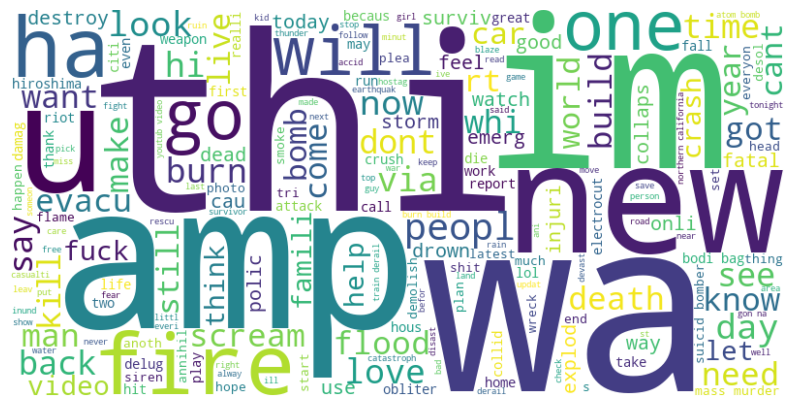

In [237]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()

3)feature extraction

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [239]:
tex = tokens.apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(tex)
print(type(X))
y = data['target']

<class 'scipy.sparse._csr.csr_matrix'>


In [240]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
location_encoder = OneHotEncoder(sparse_output=True)
X_location = location_encoder.fit_transform(data[['location']])
keywords_encoder = OneHotEncoder(sparse_output=True)
X_keywords = keywords_encoder.fit_transform(data[['keyword']])  
X_combined = hstack([X, X_location, X_keywords])


4)model building

In [241]:
def plot_confusion_matrix(y_test, preds, title):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

(7613, 21736)
Accuracy: 78.20%
Confusion Matrix:
 [[733 141]
 [191 458]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       874
           1       0.76      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



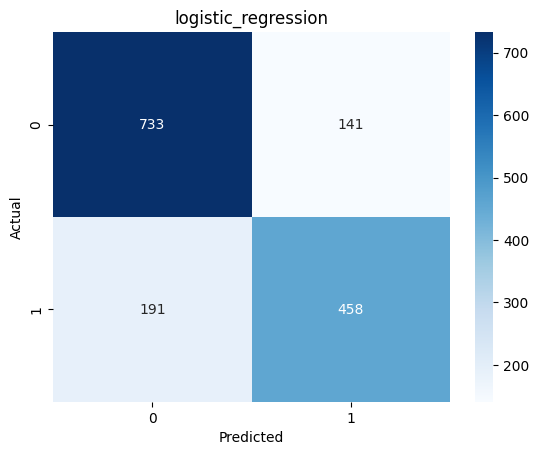

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
print(X_combined.shape)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test,y_pred,'logistic_regression')

Accuracy: 77.68%
Confusion Matrix:
 [[722 152]
 [188 461]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



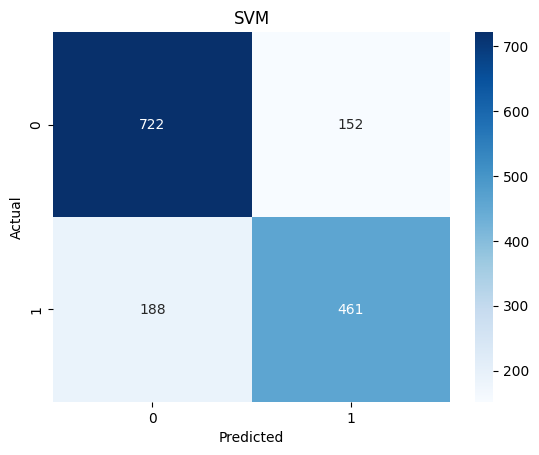

In [243]:
svm_model = SVC(kernel='linear', random_state=42,probability=True) 
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test,y_pred,'SVM')

Accuracy: 77.68%
Confusion Matrix:
 [[725 149]
 [191 458]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



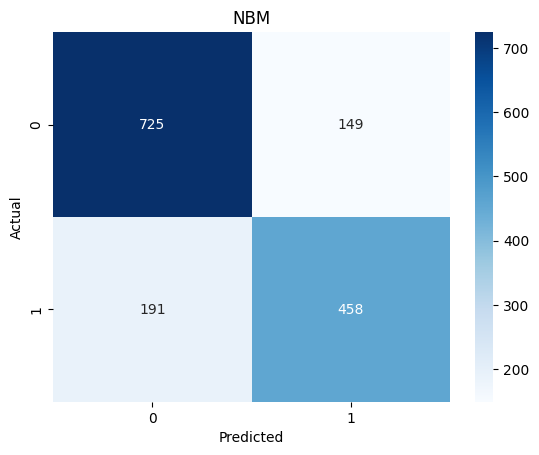

In [244]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test,y_pred,'NBM')

5)hyperparameter tuning

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2)
param_grid_lr = {
    'C': [0.1, 1, 10], 
}
param_grid_svm = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear', 'rbf'], 
}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Cross-Validation Accuracy (LR):", grid_search_lr.best_score_)
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)
print("Test Performance (LR):")
print(classification_report(y_test, y_pred_lr))


Best Parameters for Logistic Regression: {'C': 10}
Best Cross-Validation Accuracy (LR): 0.7821018062397374
Test Performance (LR):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       934
           1       0.73      0.73      0.73       589

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [247]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 1}
Best Score: 0.7845648604269295
Accuracy on Test Set: 0.7997


In [250]:
nb = MultinomialNB()
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  
    'fit_prior': [True, False]            }

grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_nb.best_params_}")
print(f"Best Score: {grid_search_nb.best_score_}")

best_nb = grid_search_nb.best_estimator_
y_pred = best_nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Best Score: 0.7816091954022988
Accuracy on Test Set: 0.7938
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       934
           1       0.73      0.74      0.73       589

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



6)visualisation analysis

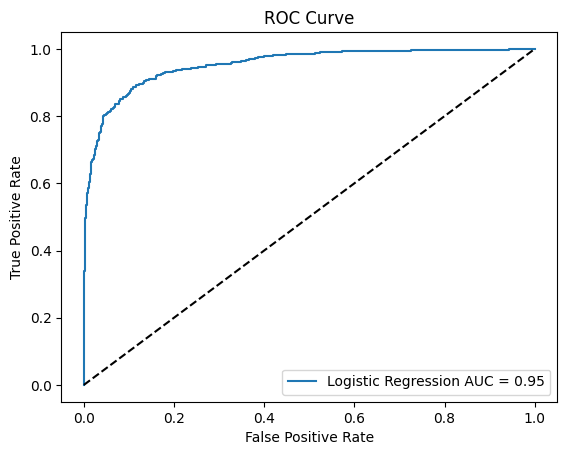

In [251]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Logistic Regression AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

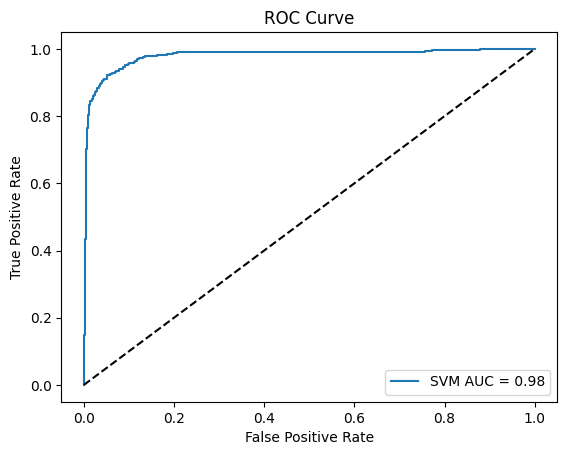

In [252]:
fpr, tpr, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'SVM AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

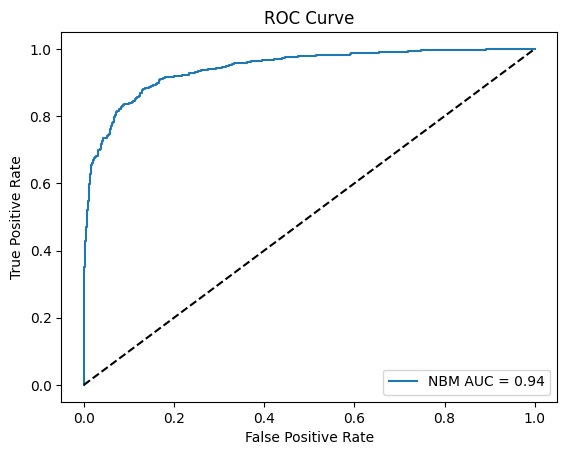

In [253]:
fpr, tpr, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'NBM AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

NOW FOR THE TEST SET

In [254]:
test_data=pd.read_csv("/Users/sahil/Programs/projects/MSA/Assignments/test.csv")

In [255]:
def clean_location_and_keyword(df):
    if 'location' in df.columns:
        df['location'] = df['location'].fillna('Unknown') 
    if 'keyword' in df.columns:
        df['keyword'] = df['keyword'].fillna('Unknown')  
    return

clean_location_and_keyword(test_data)


In [256]:
def clean_tex(tex):
    cleaned_tweet = re.sub(r"[^a-zA-Z\s]", "", tex)
    return cleaned_tweet.strip()
cleaned_text = test_data['text'].apply(clean_tex)

In [257]:
test_tokens=cleaned_text.apply(lambda a:word_tokenize(a))
stop_words = set(stopwords.words('english'))
test_tokens = test_tokens[~tokens.isin(stop_words)] 
test_tokens= test_tokens.apply(lambda token_list: [token.lower() for token in token_list])
print(test_tokens[16])

['sunkxssedharry', 'will', 'you', 'wear', 'shorts', 'for', 'race', 'ablaze']


In [258]:
porter_stemmer = PorterStemmer()
def stem_sentence(test_tokens):
    return [porter_stemmer.stem(word) for word in test_tokens]
test_tokens=test_tokens.apply(stem_sentence)

In [259]:
tex = test_tokens.apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(stop_words='english')
test_X = vectorizer.fit_transform(tex)
print(type(X))

<class 'scipy.sparse._csr.csr_matrix'>


In [260]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
location_encoder = OneHotEncoder(sparse_output=True)
X_location = location_encoder.fit_transform(test_data[['location']])
keywords_encoder = OneHotEncoder(sparse_output=True)
X_keywords = keywords_encoder.fit_transform(test_data[['keyword']])  
X_combined1 = hstack([test_X, X_location, X_keywords])
print(X_combined1.shape)
print(X_train.shape)

(3263, 12002)
(6090, 21736)


In [261]:
y_pred_mb=nb_model.predict(X_combined)

In [262]:
print(type(test_data['id']))
lr=pd.Series(y_pred_lr)
mb=pd.Series(y_pred_mb)
output_df = pd.DataFrame({
    'id': test_data['id'],
    'text': test_data['text'],
    'prediction': lr
})
print(output_df.iloc[[14]])

<class 'pandas.core.series.Series'>
    id      text  prediction
14  45  Awesome!         0.0


In [263]:
output_csv_path = "/Users/sahil/Programs/projects/MSA/Assignments/submission.csv"
output_df.to_csv(output_csv_path, index=False)
